In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Standard library imports.
from datetime import timedelta, datetime
import pprint
import pickle
import json
from typing import List, Dict

# Related third party imports.
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd

# Local application/library specific imports.
from cerebralcortex.cerebralcortex import CerebralCortex

/home/mperf/anaconda3/envs/myenv/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/mperf/anaconda3/envs/myenv/lib/python3.6/site-packages/pympler/asizeof.py:217: DeprecationWarning: unicode_internal codec has been deprecated
  u = u.encode('unicode-internal')  # see .../Lib/test/test_sys.py
/home/mperf/anaconda3/envs/myenv/lib/python3.6/importlib/_bootstrap_external.py:426: ImportWarning: Not importing directory /home/mperf/anaconda3/envs/myenv/lib/python3.6/site-packages/google: missing __init__
  _warnings.warn(msg.format(portions[0]), ImportWarning)
/home/mperf/anaconda3/envs/myenv/lib/python3.6/importlib/_bootstrap_external.py:426: ImportWarning: Not importing directory /home/mperf/anaconda3/envs/myenv/lib/python3.6/site-packages/mpl_toolkits: missing __init__
  _warnings.warn(msg.format(portions[0]), ImportWarning)
/home/mperf/anaconda3/envs/myenv/lib/p

In [3]:
# Set important paths
config_path = '../config/'
data_path = '../data/'

# Load all user IDs
with open(config_path+'users.json', 'r') as f:
    USR_IDS = json.load(f)

# Load all users' work days
with open(data_path+'usr_work_days.pkl', 'rb') as f:
    usr_work_days = pickle.load(f)
    
# Load all users' groundthruths
with open(data_path+'at_desk_groundtruth.pkl', 'rb') as f:
    at_desk_groundtruth = pickle.load(f)

In [4]:
for usr_id in at_desk_groundtruth:
    if at_desk_groundtruth[usr_id]:
        print(type(at_desk_groundtruth[usr_id][0][0]))

<class 'datetime.datetime'>
<class 'datetime.datetime'>
<class 'datetime.datetime'>
<class 'datetime.datetime'>
<class 'datetime.datetime'>
<class 'datetime.datetime'>
<class 'datetime.datetime'>


(array([1540245.,     382.,      23.,      16.,       7.,       7.,
             12.,      10.,       2.,       5.]),
 array([0.025 , 0.1225, 0.22  , 0.3175, 0.415 , 0.5125, 0.61  , 0.7075,
        0.805 , 0.9025, 1.    ]),
 <a list of 10 Patch objects>)

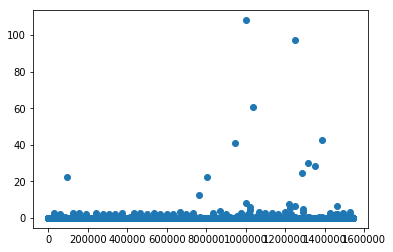

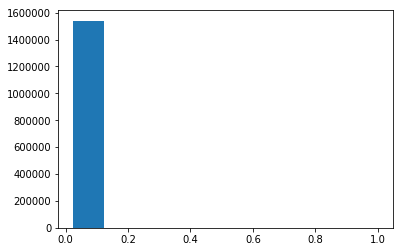

In [5]:
step_cnt_fn = '/home/mperf/sandeep/Codes/data/03996723-2411-4167-b14b-eb11dfc33124/step_cnt20180102.npz'
accel_fn = '/home/mperf/sandeep/Codes/data/03996723-2411-4167-b14b-eb11dfc33124/accel20180102.npz'
gyro_fn = '/home/mperf/sandeep/Codes/data/03996723-2411-4167-b14b-eb11dfc33124/gyro20180102.npz'
act_type_fn = '/home/mperf/sandeep/Codes/data/03996723-2411-4167-b14b-eb11dfc33124/act_type20180102.npz'
arrays = np.load(accel_fn)
np.set_printoptions(suppress=True)
accel = arrays['arr_0']


plt.figure()
plt.plot(np.ediff1d(accel[:, 0]), 'o')
plt.figure()
plt.hist(np.ediff1d(accel[:, 0]), range=(0.025, 1))
# print(file['arr_0'][0][0] -test['arr_0'][1][0])

In [10]:
import pdb
def resample(x, ts_new):
    'Resamples x with freq from start_t to end_t'
    
    f_new = interp1d(x[:, 0], x[:, 1:], kind='zero', axis=0)
    
    x_new = np.hstack((ts_new.reshape((-1, 1)), f_new(ts_new)))
    return x_new

# def is_at_desk(ts, groundtruth):
#     for start_t, end_t in groundtruth:
#         if ts >= start_t.timestamp() and ts <= end_t.timestamp():
#             return 1
#     return 0

# def prepare_labels(groundtruth, ts_new):
#     'Generates a series of labels for ts_new based on groundtruth'
#     results = list()
#     for ts in ts_new:
#         results.append(is_at_desk(ts, groundtruth))
#     return np.array(results)




INTERP_FREQ = 20.0 # 20.0 HZ

for usr_id in usr_work_days:
    usr_path = data_path+usr_id+'/'
    for day in usr_work_days[usr_id]:

        accel = np.load(usr_path+'accel'+day+'.npz')['arr_0']
        act_type = np.load(usr_path+'act_type'+day+'.npz')['arr_0']
        gyro = np.load(usr_path+'gyro'+day+'.npz')['arr_0']
        step_cnt = np.load(usr_path+'step_cnt'+day+'.npz')['arr_0']

        # Find the latest start time among all sensors
        start_t = max([accel[0][0], act_type[0][0], 
                       gyro[0][0], step_cnt[0][0]])
        
        # Find the earliest end time among all sensors
        end_t = min([accel[-1][0], act_type[-1][0], 
                     gyro[-1][0], step_cnt[-1][0]])
        
        # Generate new timestamps
        ts_new = np.arange(start_t, end_t, 1.0/INTERP_FREQ)
        
        df = pd.DataFrame({'val' : np.zeros(ts_new.shape)}, index=pd.to_datetime(ts_new, unit='s'))
  
        for start_t, end_t in at_desk_groundtruth[usr_id]:
            df[start_t : end_t] = 1
        
        
        accel = resample(accel, ts_new)
        offset = accel[:, 2]
        act_type = resample(act_type, ts_new)
        gyro = resample(gyro, ts_new)
        step_cnt  = resample(step_cnt, ts_new)
        labels = np.asarray(df.values).reshape(-1)
# prepare_labels(at_desk_groundtruth[usr_id], ts_new)
        
        assert(ts_new.shape[0] == accel.shape[0])
        assert(ts_new.shape[0] == act_type.shape[0])
        assert(ts_new.shape[0] == gyro.shape[0])
        assert(ts_new.shape[0] == step_cnt.shape[0])
        assert(ts_new.shape[0] == labels.shape[0])
        
        
        np.savez(usr_path+'data'+day+'.npz',
                 ts=ts_new,
                 offset=,
                 accel=accel[:, 3:],
                 act_type=act_type[:, 3:],
                 gyro=gyro[:, 3:],
                 step_cnt=step_cnt[:, 3:],
                 labels=labels)

[-28800000. -28800000. -28800000. ... -28800000. -28800000. -28800000.]
[-28800000. -28800000. -28800000. ... -28800000. -28800000. -28800000.]
[-28800000. -28800000. -28800000. ... -28800000. -28800000. -28800000.]
[-28800000. -28800000. -28800000. ... -28800000. -28800000. -28800000.]


KeyboardInterrupt: 